In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from math import ceil
import torch
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append('../utils/')
from data_utils import get_folders
from train_utils import train
from diagnostic_tools import count_params
    
torch.cuda.is_available()

True

In [3]:
torch.backends.cudnn.benchmark = True

# Create data iterators

In [4]:
batch_size = 128

In [5]:
train_folder, val_folder = get_folders()

train_iterator = DataLoader(
    train_folder, batch_size=batch_size, num_workers=4,
    shuffle=True, pin_memory=True
)

val_iterator = DataLoader(
    val_folder, batch_size=256, num_workers=4,
    shuffle=False, pin_memory=True
)

# number of training samples
train_size = len(train_folder.imgs)
train_size

100000

In [6]:
# number of validation samples
val_size = len(val_folder.imgs)
val_size

10000

# Model

In [7]:
from get_densenet import get_model

In [8]:
model, criterion, optimizer = get_model()

In [9]:
# number of params in the model
count_params(model)

1000668

# Train

In [10]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

n_epochs = 40
n_batches = ceil(train_size/batch_size)

lr_scheduler = ReduceLROnPlateau(
    optimizer, mode='max', factor=0.1, patience=6, 
    verbose=True, threshold=0.01, threshold_mode='abs'
)

n_batches

782

In [11]:
%%time
all_losses, _ = train(
    model, criterion, optimizer, 
    train_iterator, n_epochs, n_batches, 
    val_iterator, validation_step=782, n_validation_batches=40, 
    saving_step=None, lr_scheduler=lr_scheduler
)
# epoch logloss    accuracy     top5_accuracy time  (first value: train, second value: val)

1.00  4.569 4.293  0.067 0.100  0.207 0.285  30.612
2.00  3.922 3.788  0.141 0.162  0.363 0.398  29.250
3.00  3.719 3.860  0.171 0.159  0.415 0.386  29.331
4.00  3.606 3.979  0.191 0.155  0.442 0.370  29.324
5.00  3.532 3.698  0.204 0.187  0.459 0.441  29.204
6.00  3.477 3.637  0.212 0.196  0.474 0.439  29.391
7.00  3.430 3.558  0.221 0.199  0.483 0.464  29.300
8.00  3.395 3.621  0.227 0.199  0.492 0.450  29.295
9.00  3.377 3.474  0.231 0.209  0.498 0.475  29.249
10.00  3.348 3.345  0.235 0.227  0.504 0.505  29.229
11.00  3.336 3.727  0.237 0.191  0.505 0.437  29.358
12.00  3.325 3.432  0.239 0.225  0.509 0.488  29.294
13.00  3.319 3.506  0.242 0.221  0.511 0.477  29.397
14.00  3.301 3.563  0.244 0.220  0.514 0.480  29.236
15.00  3.293 3.265  0.245 0.246  0.519 0.523  29.358
16.00  3.286 3.418  0.249 0.225  0.520 0.486  29.206
17.00  3.277 3.491  0.250 0.221  0.521 0.486  29.231
18.00  3.269 3.432  0.250 0.231  0.522 0.487  29.272
19.00  3.270 3.627  0.250 0.200  0.523 0.444  29.259
20

# Loss/epoch plots

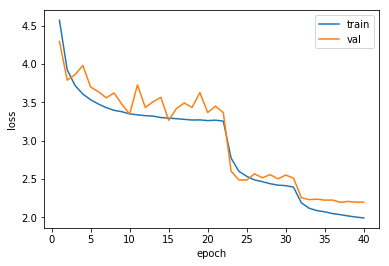

In [12]:
epochs = [x[0] for x in all_losses]
plt.plot(epochs, [x[1] for x in all_losses], label='train');
plt.plot(epochs, [x[2] for x in all_losses], label='val');
plt.legend();
plt.xlabel('epoch');
plt.ylabel('loss');

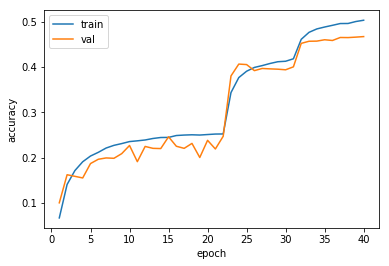

In [13]:
plt.plot(epochs, [x[3] for x in all_losses], label='train');
plt.plot(epochs, [x[4] for x in all_losses], label='val');
plt.legend();
plt.xlabel('epoch');
plt.ylabel('accuracy');

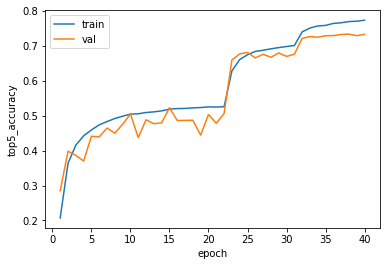

In [14]:
plt.plot(epochs, [x[5] for x in all_losses], label='train');
plt.plot(epochs, [x[6] for x in all_losses], label='val');
plt.legend();
plt.xlabel('epoch');
plt.ylabel('top5_accuracy');

# Save

In [15]:
model.cpu();
torch.save(model.state_dict(), 'model.pytorch_state')